## Summary 
This is a binary classification problem with a highly imbalanced dataset (ratio of approx. 1:600) that is about distinguishing fraudulent card transactions from non-fraudulent transactions. The input features are the card purchase amount and a set of 29 principal components (PCs) from principal component analysis (PCA). To tackle this challenge I attempted to use (1) both over and under sampling, (2) feature removal, (3) outlier removal (only from the not fraudulent class, because I did not want to lose any examples from the fraudulent class) and (4) various ML models and hyperparameters (with GridSearchCV).

#### The Final Scores are as Follows: 

| Model | ROC AUC for Train/Test Dataset | ROC AUC for Validation Dataset |
| --- | --- |  --- |
| Logistic Regression | 0.983 | 0.947|
| Random Forest |  0.983 | 0.919 |
| Support Vector Machine | 0.985 | 0.931 |
| Gradient Boosting | 0.984 | 0.931 |

Meaning the Logistic Regression model had the best performance on the validation set, but all models performed very similarly. Note that the ROC AUC is the [Area Under the Receiver Operating Characteristic Curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), a metric that can handle class imbalances. 

When studying the above results we can see most models have highly similar performances (according to this metric). Analysis of the confusion matrices would suggest I have made a good filter to identify "suspicious transactions", as whilst many non-fraudulent transactions are labelled as fraud, almost all fraudulent transactions were correctly identified. I think this is likely in part due to using outlier removal on the not fraud class, meaning more uncertain cases would be trained to predict fraud over not fraud. In a practical context this may actually be ideal. One can imagine a scenario where a fairly rapid pre-filtering model (something like this) is used to identify potentially fraudulent transactions (but casts a wide enough net to ultimately catch many non-fraudulent ones too). These transactions could then be passed onto a more advanced model (that could for instance also consider a given card user's most recent purchases, location etc..) to hopefully make a more accurate decision at that point. If this was the goal, then the model developed here could be further improved by working on the outlier removal of the non-fraudulent data (or using harsher filtering criteria) and/or altering the cost function used to make false negatives more undesirable.  


### Links to the Different Sections of the Notebook

### [Setting up the Environment and Reading in the Dataset](#Enviro_Setup)

### [Exploratory Data Analysis](#Exploratory_Data_Analysis)

### [Comparing the Distributions of each Feature to the Target Classes](#Feat_Distrib)

### [Linear and Non-Linear Correlations to the Target Class](#Correlations)

### [Some Initial ML Model Tests and Outlier Removal](#Initial_ML)

### [Final Model Building](#Final_ML)

### [Model Evaluations](#Model_Eval)

### [Comparison of the Feature Importances for the Different Models](#Feauture_Importance)

<a id='Enviro_Setup'></a> 

## Setting up the Environment and Reading in the Dataset

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
# classics
import numpy as np 
import pandas as pd 

# sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# sklearn bits and bobs. 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

# imblearn library for imbalanced dataset.
from imblearn.pipeline import Pipeline, make_pipeline 
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

# plotting
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
df = pd.read_csv("../input/creditcardfraud/creditcard.csv")
display(df.head(5))
display(df.shape)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


(284807, 31)

 <a id='Exploratory_Data_Analysis'></a> 

## Exploratory Data Analysis
In this section we first check to see if the data is okay (things like: is there missing data? And is the data is set to the correct data type(s)?). Then I will move on to looking at the relationships between the features and the targets.  

In [4]:
# No missing data to deal with. 
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
# Unsurpsingly large class imbalance to deal with...
display(df['Class'].value_counts())
fraudRatio = round(df['Class'].value_counts()[0] / df['Class'].value_counts()[1], 1)
print(f"Ratio of non-fradulent vs fraudulent cases is: {fraudRatio}")

0    284315
1       492
Name: Class, dtype: int64

Ratio of non-fradulent vs fraudulent cases is: 577.9


In [6]:
# Reassuring to see some difference between classes along the PCs.
display(df.groupby('Class').mean())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,94838.202258,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,...,-0.000644,-0.001235,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022
1,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321


In [7]:
# "Time" can be dropped as each purchases is unrelated to one another. 
# (And if there is an apparent relationship, it is just a coincidence.)
df = df.drop(["Time"], axis=1)
df.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df.dtypes # already correctly set

V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

 <a id='Feat_Distrib'></a>

## Comparing the Distributions of each Feature to the Target Classes
Below, violin plots are used to compare the distributions of each feature to the target dataset. 
Beyond showing that there are differences in the distributions between each class (good!), an argument can be made towards performing some kind of outlier removal prior to training the model. Depending on the model used, outliers can have a relatively large impact on the model (sometimes referred to as "high leverage").

In [9]:
fig = make_subplots(rows=6, cols=5, subplot_titles=list(df.columns))  

for row_num in range(1, 7):
    start_list = 0 + ((row_num-1) * 5)
    end_list = 5 + ((row_num-1) * 5)
    for idx, feature in enumerate(list(df.columns)[start_list: end_list]):
        fig.add_trace(go.Violin(x=df["Class"][df["Class"] == 1],
                                y=df[feature][df["Class"] == 1],
                                legendgroup="Fraud", scalegroup="Fraud", name="Fraud",
                                line_color="blue"),
                      row=row_num, col=(idx+1))
        fig.add_trace(go.Violin(x=df["Class"][df["Class"] == 0][::100], # 1 in 100 otherwise will crash...
                                y=df[feature][df["Class"] == 0][::100], # 1 in 100 otherwise will crash...
                                legendgroup="Not Fraud", scalegroup="Not Fraud", name="Not Fraud",
                                line_color='orange'),
                      row=row_num, col=(idx+1))

fig.update_traces(meanline_visible=True)
fig.update_layout(showlegend=False, violingap=0, height=1500,
                  title_text="Distributions of Fraudulent vs Not Fraudulent Transactions along each PC and Amount")
fig.show()

 <a id='Correlations'></a>

## Linear and Non-Linear Correlations to the Target Class: Are All of The Features Important for Prediction?

* Below we will first generate a correlation matrix (that will look for only linear correlations). Given that features V1-V28 were generated from PCA it is not a surprise to see that all PCs have 0 linear correlation with each other. We can also see the largest absolute correlation value between two features ("V2" and "Amount") is 0.53, meaning we do not need to worry about any potential issues from multicollinearity.  

* Perhaps a better question is do we need all these features? To help with this, below both the linear correlation and the mutual information (able to find non-linear relationships) for all features to the target is shown. These results clearly suggest that features such as "V13", "V15", "V22" to "V26" (and others) could be removed prior to machine learning. This will be investigated later.

In [10]:
# linear correlations
corrM = df.corr()
linear_corr_target = np.around(corrM.values[29], 4) # just to the target. 

# normalised mutual info to target variable. (range between 0 and 1)
x = df.to_numpy()
y = df["Class"].to_numpy()

mi = mutual_info_classif(x, y, discrete_features=False)
mi /= np.max(mi)

mat_fig = go.Figure(data=go.Heatmap(
                z=corrM.values,
                x=corrM.index.values,
                y=corrM.columns.values,
                colorscale=px.colors.diverging.RdBu,
                zmin=-1, zmax=1
))
mat_fig.update_layout(title="Linear Correlation Matrix")
mat_fig.show()


bar_df = pd.DataFrame()
bar_df["Feature"] = list(df.columns)
bar_df["Linear Correlation"] = list(linear_corr_target)
bar_df["Mutual Information"] = list(mi)

bar_fig = go.Figure(data=[
    go.Bar(name='Linear Correlation', x=bar_df["Feature"], y=bar_df["Linear Correlation"]),
    go.Bar(name='Normalised MI', x=bar_df["Feature"], y=bar_df["Mutual Information"])
])
bar_fig.update_layout(barmode="group", title="Linear Correlation vs Normalised Mutual Information for Each Feature to the Target")
bar_fig.show()

<a id='Initial_ML'></a> 

## Initial Machine Learning Tests Prior to Proper Model Building.

#### Above we saw that:
1. There is a large class imbalance to be dealt with.
2. There are potentially outliers present. Further, the violin plots showed us some of the distributions do not have a gaussian distribution. This means that the outlier removal method chosen should be okay working with non-normal distributions.
3. Some features could be removed from the model as they do not appear to contribute much. 


#### Additional Considerations: 
1. Given what I have described above, there is a clear danger of having way too many things to try in combination with one another. I will therefore first test some of the ideas above out on a single, rapid to train model (logistic regression), and then make some decisions based on that on what to take forward for a second round with some other models. Edit: I added random forest after based on some observations. 

#### Therefore:
1. Building pipelines will be valuable here due to the desire to evaluate the impact of multiple things (e.g. outlier removal, feature removal, up and down sampling). 
2. As I want to evaluate multiple protocols I will use stratified k-fold cross-validation. This means my training and testing data will be combined and I will use this approach to select my best model before final validation of this model with the "evaluation set".

3. I will use the Interquartile Range Method to try to detect and remove outliers from the model. We have so few samples of fraud that we will keep all of them, but for not fraud samples we will apply outlier removal. 

4. I will evaluate my models with the roc_auc_score (as recommended by the challenge author). This provides a balanced view of model quality for both imbalanced and balanced datasets (test_train runs will always have a balanced dataset so technically not required at this stage).

In [11]:
# First and foremost, seperate my test and training set from my validation set before anything else. 
# 15% to validation, rest to training and testing with cross validation. 
# Use of the "stratify" parameter is important here as this way we will have... 
# a good mix of fraudulent and not fraudulent samples in both datasets.
X = (df.drop("Class", axis=1)).to_numpy() 
y = (df["Class"]).to_numpy() 

X_train_test, X_validation, y_train_test, y_validation = train_test_split(
                                                            X, y, test_size = 0.15, stratify=y, random_state=1)

# confirms there is a well balanced number of 1's and 0's for both sets.
np.average(y_train_test), np.average(y_validation) 

(0.0017266662535886156, 0.0017321286456626562)

In [12]:
# For the outlier detection, I will put train_test data back into a dataframe so it is easier to manipulate.
df_train_test = pd.DataFrame(X_train_test, columns=list(df.columns[0:29])) 
df_train_test["Class"] = y_train_test
df_train_test.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.737662,0.877699,2.238997,0.080510,-0.218879,-0.599034,0.415185,0.047494,-0.078789,-0.620481,...,-0.022426,-0.217854,-0.220635,0.331284,0.358890,-0.592746,-0.128089,-0.017326,8.99,0
1,1.004793,-0.672297,-0.445963,0.667430,1.533548,4.418254,-0.925142,1.128421,1.129803,-0.350665,...,-0.443313,-1.195307,-0.058603,0.999845,0.621183,-0.532953,0.059482,0.040705,100.44,0
2,1.776042,-1.071451,-0.285485,0.752185,-1.230161,-0.426358,-0.679677,-0.055563,-0.146593,0.946692,...,-0.392576,-0.919301,0.331524,-0.139372,-0.589481,-0.933234,0.054832,0.004922,151.00,0
3,1.258513,-0.794463,1.057970,-0.738204,-1.396441,-0.054061,-1.208656,0.221275,-0.636797,0.736613,...,0.475977,1.295774,-0.063791,0.273366,0.285506,-0.050052,0.047237,0.015254,19.95,0
4,1.354977,-0.734493,1.365681,-0.624978,-1.739542,-0.517413,-1.300679,0.018142,-0.229972,0.572564,...,0.438772,1.251905,-0.084491,0.452011,0.327942,-0.044055,0.060536,0.033855,9.99,0


In [13]:
# Below 2 helper functions are for outlier removal. 
def calc_iqr(x, cut_strength):
    """Calculate the interquartile range for a single feature.
    x is the dataframe column and cut_strength tunes the strength of the cut_off used.
    Output is the lower and upper bounds for filtering."""
    q25, q75 = np.percentile(x, 25), np.percentile(x, 75)
    iqr = q75 - q25
    # calculate the outlier cutoffs
    cut_off = iqr * cut_strength
    lower, upper = (q25 - cut_off), (q75 + cut_off)
    return lower, upper   

def outlier_removal(df, feature_columns, cut_strength):
    """Take as input (1) the dataframe to perform outlier removal on
    (2) the columns indexes which contain features to perform outlier removal on and
    (3) the cutoff strength for the outlier calculation (see above function).
    Determine the lower and upper limits for each column and append any rows which are outside the outliers. 
    Remove those rows if they are part of the not fraud class.
    Returns the prepared dataframe and states how many rows were removed."""
    outlier_list = []
    for col in feature_columns:
        lower, upper = calc_iqr(df[col], cut_strength)
        outliers = list( np.where( (df[col] < lower) | (df[col] > upper) ) [0])
        outlier_list.extend(outliers)
    outlier_set = set(outlier_list) # unique list of all rows that meet deletion requirements. 
    # prevents fraud rows from being deleted. 
    must_keep = list(np.where(df["Class"] == 1)[0])
    removal_list = [x for x in outlier_set if x not in must_keep]
    df_ready = df.drop(removal_list, axis="index")
    print(f"{len(removal_list)} outliers removed from the train_test dataset")
    return df_ready

In [14]:
# only those that seemed to be show a reasonable degree of correlation to the target variable are included here. 
# (Decided based on bar chart generated above.) 
# Amount also not included as seens unreasonable to remove high cost outliers especially from only one class. 
feature_columns = ["V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V14",
                   "V16", "V17", "V18", "V19","V21", "V27", "V28"] 

cut_strength = 3
df_train_test_outliers_v1 = outlier_removal(df_train_test, feature_columns, cut_strength)

cut_strength = 5
df_train_test_outliers_v2 = outlier_removal(df_train_test, feature_columns, cut_strength)

cut_strength = 7
df_train_test_outliers_v3 = outlier_removal(df_train_test, feature_columns, cut_strength)

# remake the train_test arrays. 
X_train_test_outliers_v1 = (df_train_test_outliers_v1.drop("Class", axis=1)).to_numpy() 
y_train_test_outliers_v1 = (df_train_test_outliers_v1["Class"]).to_numpy()

X_train_test_outliers_v2 = (df_train_test_outliers_v2.drop("Class", axis=1)).to_numpy() 
y_train_test_outliers_v2 = (df_train_test_outliers_v2["Class"]).to_numpy()

X_train_test_outliers_v3 = (df_train_test_outliers_v3.drop("Class", axis=1)).to_numpy() 
y_train_test_outliers_v3 = (df_train_test_outliers_v3["Class"]).to_numpy()

31764 outliers removed from the train_test dataset
13630 outliers removed from the train_test dataset
8491 outliers removed from the train_test dataset


<a id='LogReg_pipeline'></a>

## Define the Initial Testing Pipeline with Logistic Regression

I will try two approaches to handle the class imbalances present for the 4 train_test datasets above. After the over/undersampling I will scale the data prior to model building.

**Version 1:** Undersample the Dataset to get a 1 to 1 match between the classes. 

**Version 2:** Oversample the Dataset with Borderline-SMOTE to get a 1 to 1 match between the classes. 

**Version 3 + 4:** After completing the above two versions and observing no notable difference with over sampling. I decided to try a different ML model (random forest) which should be more "data hungry" and see if this also is insensitive to under vs oversampling.

Borderline-SMOTE is a special type of oversampling technique that only makes new versions of minority class members that are rather ambiguous/uncertain to classify. So the extra examples generated are more likely to be useful to the model (we do not need to upsample in regions that are easily classified as 1 or 0 already). 

It is [recommended to combine oversampling with undersampling](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/), and this will also notably reduce model training time. So we will upsample the fraud examples to 1:20 and then downsample the major class afterwards to get a 1:1 ratio. 


In [15]:
# Pipeline Version 1 - Undersample the Dataset to get a 1 to 1 match between the classes.
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1) 
undersample = RandomUnderSampler(sampling_strategy=1, random_state=1) 

pipeline_1_steps = [("under", undersample),
                    ("scaler", StandardScaler()),
                    ("feat_selector", SelectKBest(mutual_info_classif)),
                    ("log_regression", LogisticRegression(random_state=1))
                   ]
pipeline_1 = Pipeline(pipeline_1_steps)

pipeline_1_params = {
    "scaler": [StandardScaler(), MinMaxScaler()],
    "feat_selector__k": [12, 15, 18, 20, 23, 26, 29],
    "log_regression__solver": ["liblinear", "lbfgs"],
}

# Apply the pipeline defined above on all 4 different datasets. 
all_models = {
    "Original" : [X_train_test, y_train_test],
    "Outlier Version 1" : [X_train_test_outliers_v1, y_train_test_outliers_v1],
    "Outlier Version 2" : [X_train_test_outliers_v2, y_train_test_outliers_v2],
    "Outlier Version 3" : [X_train_test_outliers_v3, y_train_test_outliers_v3],
}

best_num_feats = []
best_solver = []
best_scaler = []
best_score = []
best_stdev = []

for model_version in all_models:
    clf_pipeline = GridSearchCV(pipeline_1, pipeline_1_params, scoring="roc_auc", cv=cv, refit=True, n_jobs=-1)
    clf_pipeline.fit(all_models[model_version][0], all_models[model_version][1])
    
    best_num_feats.append(clf_pipeline.best_params_["feat_selector__k"])
    best_solver.append(clf_pipeline.best_params_["log_regression__solver"])
    best_scaler.append(clf_pipeline.best_params_["scaler"])
    best_score.append(clf_pipeline.best_score_)
    best_stdev.append(clf_pipeline.cv_results_["std_test_score"][clf_pipeline.best_index_])
    
# Build a df to present the results. 
df_results = pd.DataFrame(data={"Model Version": ["Original", "Outlier Version 1", "Outlier Version 2", "Outlier Version 3"],
                                "Best Number of Features": best_num_feats,
                                "Best Solver": best_solver,
                                "Best Scaler": best_scaler,
                                "Best Score": best_score,
                                "Best Score's STDev": best_stdev
                               })
df_results

,Model Version,Best Number of Features,Best Solver,Best Scaler,Best Score,Best Score's STDev
0,Original,23,lbfgs,MinMaxScaler(),0.981197,0.007831
1,Outlier Version 1,23,lbfgs,MinMaxScaler(),0.983024,0.009298
2,Outlier Version 2,23,lbfgs,MinMaxScaler(),0.982431,0.008618
3,Outlier Version 3,23,lbfgs,MinMaxScaler(),0.982155,0.008829


In [16]:
# Pipeline Version 2 - Over sample the Dataset to get a 1 to 1 match between the classes.
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3) 

oversample = BorderlineSMOTE(sampling_strategy=0.05, random_state=1) # 1 in 20 ratio at this point. 
undersample = RandomUnderSampler(sampling_strategy=1, random_state=1) 

pipeline_2_steps = [('over', oversample),
                    ('under', undersample),
                    ('scaler', StandardScaler()),
                    ('feat_selector', SelectKBest(mutual_info_classif)),
                    ('log_regression', LogisticRegression(random_state=1, max_iter=200))
                   ]
pipeline_2 = Pipeline(pipeline_2_steps)

pipeline_2_params = {
    "scaler": [StandardScaler(), MinMaxScaler()],
    "feat_selector__k": [21, 23, 25], # number of options reduced based on observations from Pipeline Version 1
    "log_regression__solver": ["liblinear", "lbfgs"],
}

# Apply the pipeline defined above on all 4 different datasets. 
all_models = {
    "Original" : [X_train_test, y_train_test],
    "Outlier Version 1" : [X_train_test_outliers_v1, y_train_test_outliers_v1],
    "Outlier Version 2" : [X_train_test_outliers_v2, y_train_test_outliers_v2],
    "Outlier Version 3" : [X_train_test_outliers_v3, y_train_test_outliers_v3],
}

best_num_feats = []
best_solver = []
best_scaler = []
best_score = []
best_stdev = []

for model_version in all_models:
    clf_pipeline = GridSearchCV(pipeline_2, pipeline_2_params, scoring="roc_auc", cv=cv, refit=True, n_jobs=-1)
    clf_pipeline.fit(all_models[model_version][0], all_models[model_version][1])
    
    best_num_feats.append(clf_pipeline.best_params_["feat_selector__k"])
    best_solver.append(clf_pipeline.best_params_["log_regression__solver"])
    best_scaler.append(clf_pipeline.best_params_["scaler"])
    best_score.append(clf_pipeline.best_score_)
    best_stdev.append(clf_pipeline.cv_results_['std_test_score'][clf_pipeline.best_index_])
    
# Build a df to present the results. 
df_results = pd.DataFrame(data={"Model Version": ["Original", "Outlier Version 1", "Outlier Version 2", "Outlier Version 3"],
                                "Best Number of Features": best_num_feats,
                                "Best Solver": best_solver,
                                "Best Scaler": best_scaler,
                                "Best Score": best_score,
                                "Best Score's STDev": best_stdev
                               })
df_results

,Model Version,Best Number of Features,Best Solver,Best Scaler,Best Score,Best Score's STDev
0,Original,21,lbfgs,MinMaxScaler(),0.976672,0.013302
1,Outlier Version 1,21,liblinear,MinMaxScaler(),0.981520,0.009224
2,Outlier Version 2,23,liblinear,MinMaxScaler(),0.981440,0.008084
3,Outlier Version 3,23,liblinear,MinMaxScaler(),0.980480,0.007398


In [17]:
# Pipeline Version 3: Compare no oversampling and undersampling on a random forest model.
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1) 
undersample = RandomUnderSampler(sampling_strategy=1, random_state=1) 

pipeline_3_steps = [('under', undersample),
                    ('scaler', MinMaxScaler()), # doesn't matter for random forest.
                    ('feat_selector', SelectKBest(mutual_info_classif)),
                    ('rand_forest', RandomForestClassifier(random_state=1))
                   ]
pipeline_3 = Pipeline(pipeline_3_steps)

pipeline_3_params = {
    "feat_selector__k": [18, 20], # number of options reduced based on observations from Pipeline Version 1 + 2
    "rand_forest__n_estimators": [100],
}

# Apply the pipeline on only 2 datasets as testing. 
all_models = {
    "Original" : [X_train_test, y_train_test],
    "Outlier Version 3" : [X_train_test_outliers_v3, y_train_test_outliers_v3],
}

best_num_feats = []
best_solver = []
best_score = []
best_stdev = []

for model_version in all_models:
    clf_pipeline = GridSearchCV(pipeline_3, pipeline_3_params, scoring="roc_auc", cv=cv, refit=True, n_jobs=-1)
    clf_pipeline.fit(all_models[model_version][0], all_models[model_version][1])
    
    best_num_feats.append(clf_pipeline.best_params_["feat_selector__k"])
    best_solver.append(clf_pipeline.best_params_["rand_forest__n_estimators"])
    best_score.append(clf_pipeline.best_score_)
    best_stdev.append(clf_pipeline.cv_results_["std_test_score"][clf_pipeline.best_index_])
    
# Build a df to present the results. 
df_results = pd.DataFrame(data={"Model Version": ["Original", "Outlier Version 3"],
                                "Best Number of Features": best_num_feats,
                                "Best Solver": best_solver,
                                "Best Score": best_score,
                                "Best Score's STDev": best_stdev
                               })

display("Results for no Oversampling with a Random Forest:")
display(df_results)

'Results for no Oversampling with a Random Forest:'

,Model Version,Best Number of Features,Best Solver,Best Score,Best Score's STDev
0,Original,18,100,0.978434,0.011526
1,Outlier Version 3,18,100,0.979857,0.007223


In [18]:
# Pipeline Version 4: Compare no oversampling and undersampling on a random forest model.
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1) 
oversample = BorderlineSMOTE(sampling_strategy=0.05, random_state=1) # 1 in 20 ratio at this point. 
undersample = RandomUnderSampler(sampling_strategy=1, random_state=1) 

pipeline_4_steps = [("over", oversample),
                    ("under", undersample),
                    ("scaler", MinMaxScaler()), # doesn't matter for random forest.
                    ("feat_selector", SelectKBest(mutual_info_classif)),
                    ("rand_forest", RandomForestClassifier(random_state=1))
                   ]
pipeline_4 = Pipeline(pipeline_4_steps)

pipeline_4_params = {
    "feat_selector__k": [18, 20], # number of options reduced based on observations from Pipeline Version 1 + 2
    "rand_forest__n_estimators": [100],
}

# Apply the pipeline on only 2 datasets as testing.
all_models = {
    "Original" : [X_train_test, y_train_test],
    "Outlier Version 3" : [X_train_test_outliers_v3, y_train_test_outliers_v3],
}

best_num_feats = []
best_solver = []
best_score = []
best_stdev = []

for model_version in all_models:
    clf_pipeline = GridSearchCV(pipeline_4, pipeline_4_params, scoring="roc_auc", cv=cv, refit=True, n_jobs=-1)
    clf_pipeline.fit(all_models[model_version][0], all_models[model_version][1])
    
    best_num_feats.append(clf_pipeline.best_params_["feat_selector__k"])
    best_solver.append(clf_pipeline.best_params_["rand_forest__n_estimators"])
    best_score.append(clf_pipeline.best_score_)
    best_stdev.append(clf_pipeline.cv_results_["std_test_score"][clf_pipeline.best_index_])
    
# Build a df to present the results. 
df_results = pd.DataFrame(data={"Model Version": ["Original", "Outlier Version 3"],
                                "Best Number of Features": best_num_feats,
                                "Best Solver": best_solver,
                                "Best Score": best_score,
                                "Best Score's STDev": best_stdev
                               })

display("Results for Oversampling with a Random Forest:")
display(df_results)

'Results for Oversampling with a Random Forest:'

,Model Version,Best Number of Features,Best Solver,Best Score,Best Score's STDev
0,Original,20,100,0.976246,0.009089
1,Outlier Version 3,18,100,0.978482,0.008496


<a id='Final_ML'></a>

## Reflections on the Above Results And Moving on to Final Model Training 

#### Reflections:
1. Outlier removal seems to be useful, of course there is a danger here that one could overfit if the outlier removal is too aggressive (especially considering that I am only removing outliers from the not fraud class). So I will not use a too harsh outlier removal value in the upcoming model building.
2. Reducing the number of features seems to have a beneficial impact on model quality, (this is consistent with the expectations from the exploratory data analysis performed earlier). Given that this reduces model complexity, we will take this approach forward, but use a narrower range of options than what was attempted above.
3. No clear winner between MinMax and StandardScaler, so I will keep them both in the pipeline where relevant (not important for Random Forest or Gradient Boosting) 
4. Oversampling did not have any notable impact. At first I thought this could be due to the nature of ML model I chose to evaluate (logistic regression does not tend to require too much data to fit relative to other models), so I performed some tests with a random forest model too. But the results were repeated there, so I will just undersample. 

#### Model Training Time:
Now it's time to build the final classification model. 

**I will try 4 classification models:**
1. Logistic Regression
2. Random Forest
3. Support Vector Machine
4. Gradient Boosting 

In [19]:
# Final Pipeline - Model 1: Logistic Regression. 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1) 
undersample = RandomUnderSampler(sampling_strategy=1, random_state=1) 

log_regress_pipeline_steps = [("under", undersample),
                    ("scaler", StandardScaler()),
                    ("feat_selector", SelectKBest(mutual_info_classif)),
                    ("log_regress", LogisticRegression(random_state=1))
                   ]
log_regress_pipeline = Pipeline(log_regress_pipeline_steps)

log_regress_params = {
    "scaler": [StandardScaler(), MinMaxScaler()],
    "feat_selector__k": [18, 20, 22, 24],
    "log_regress__solver": ["liblinear", "lbfgs"],
}

clf_log_regress = GridSearchCV(log_regress_pipeline, log_regress_params, scoring="roc_auc", cv=cv, refit=True, n_jobs=-1)
clf_log_regress.fit(X_train_test_outliers_v1, y_train_test_outliers_v1)

# Build a df to present the results. 
log_regress_results = {
    "ML Model": ["Logissic Regression"], 
    "Best Number of Features": [clf_log_regress.best_params_["feat_selector__k"]],
    "Best Solver": [clf_log_regress.best_params_["log_regress__solver"]],
    "Best Scaler": [clf_log_regress.best_params_["scaler"]], 
    "Best Score": [clf_log_regress.best_score_],
    "Best Score's STDev": [clf_log_regress.cv_results_["std_test_score"][clf_log_regress.best_index_]],
}

log_regress_df = pd.DataFrame.from_dict(log_regress_results)

display("Best model from Logistic Regression Grid Search CV:")
display(log_regress_df)

'Best model from Logistic Regression Grid Search CV:'

,ML Model,Best Number of Features,Best Solver,Best Scaler,Best Score,Best Score's STDev
0,Logissic Regression,22,lbfgs,MinMaxScaler(),0.983246,0.009395


In [20]:
# Final Pipeline - Model 2: Random Forest. 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1) 
undersample = RandomUnderSampler(sampling_strategy=1, random_state=1) 

rand_forest_pipeline_steps = [("under", undersample),
                              ("scaler", StandardScaler()),
                              ("feat_selector", SelectKBest(mutual_info_classif)),
                              ("rand_forest", RandomForestClassifier(random_state=1))
                             ]
rand_forest_pipeline = Pipeline(rand_forest_pipeline_steps)

rand_forest_params = {
    "feat_selector__k": [18, 20, 22, 24],
    "rand_forest__n_estimators": [50, 100, 150, 200, 250],
}

clf_rand_forest = GridSearchCV(rand_forest_pipeline, rand_forest_params, scoring="roc_auc", cv=cv, refit=True, n_jobs=-1)
clf_rand_forest.fit(X_train_test_outliers_v1, y_train_test_outliers_v1)

# Build a df to present the results. 
rand_forest_results = {
    "ML Model": ["Random Forest"], 
    "Best Number of Features": [clf_rand_forest.best_params_["feat_selector__k"]],
    "Best Number of Estimators": [clf_rand_forest.best_params_["rand_forest__n_estimators"]],
    "Best Score": [clf_rand_forest.best_score_],
    "Best Score's STDev": [clf_rand_forest.cv_results_["std_test_score"][clf_rand_forest.best_index_]],
}

rand_forest_df = pd.DataFrame.from_dict(rand_forest_results)

display("Best model from Random Forest Grid Search CV:")
display(rand_forest_df)

'Best model from Random Forest Grid Search CV:'

,ML Model,Best Number of Features,Best Number of Estimators,Best Score,Best Score's STDev
0,Random Forest,22,250,0.983331,0.007511


In [21]:
# Final Pipeline - Model 3: Support Vector Machine. 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1) 
undersample = RandomUnderSampler(sampling_strategy=1, random_state=1) 

svm_pipeline_steps = [("under", undersample),
                    ("scaler", StandardScaler()),
                    ("feat_selector", SelectKBest(mutual_info_classif)),
                    ("svm", SVC(random_state=1))
                   ]
svm_pipeline = Pipeline(svm_pipeline_steps)

svm_params = {
    "scaler": [StandardScaler(), MinMaxScaler()],
    "feat_selector__k": [18, 20, 22, 24],
    "svm__C": [0.1, 1,10],
    "svm__kernel": ["rbf", "poly", "sigmoid", "linear"],  
}

clf_svm = GridSearchCV(svm_pipeline, svm_params, scoring="roc_auc", cv=cv, refit=True, n_jobs=-1)
clf_svm.fit(X_train_test_outliers_v1, y_train_test_outliers_v1)

# Build a df to present the results. 
svm_results = {
    "ML Model": ["Support Vector Machine"], 
    "Best Number of Features": [clf_svm.best_params_["feat_selector__k"]],
    "Best kernel": [clf_svm.best_params_["svm__kernel"]],
    "Best Regularization parameter": [clf_svm.best_params_["svm__C"]],
    "Best Scaler": [clf_svm.best_params_["scaler"]], 
    "Best Score": [clf_svm.best_score_],
    "Best Score's STDev": [clf_svm.cv_results_["std_test_score"][clf_svm.best_index_]],
}

svm_df = pd.DataFrame.from_dict(svm_results)

display("Best model from Support Vector Machine Grid Search CV:")
display(svm_df)

'Best model from Support Vector Machine Grid Search CV:'

,ML Model,Best Number of Features,Best kernel,Best Regularization parameter,Best Scaler,Best Score,Best Score's STDev
0,Support Vector Machine,24,rbf,1,StandardScaler(),0.985117,0.007632


In [22]:
# Final Pipeline - Model 4: Gradient Boosting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1) 
undersample = RandomUnderSampler(sampling_strategy=1, random_state=1) 

GBoost_pipeline_steps = [("under", undersample),
                    ("scaler", StandardScaler()),
                    ("feat_selector", SelectKBest(mutual_info_classif)),
                    ("GBoost", GradientBoostingClassifier(random_state=1))
                   ]
GBoost_pipeline = Pipeline(GBoost_pipeline_steps)

GBoost_params = {
    "scaler": [StandardScaler()], # shouldn't make a difference as with random forests. 
    "feat_selector__k": [18, 20, 22, 24], 
    "GBoost__n_estimators": [100, 200, 300, 400, 500],
}

clf_GBoost = GridSearchCV(GBoost_pipeline, GBoost_params, scoring="roc_auc", cv=cv, refit=True, n_jobs=-1)
clf_GBoost.fit(X_train_test_outliers_v1, y_train_test_outliers_v1)

# Build a df to present the results. 
GBoost_results = {
    "ML Model": ["Gradient Boosting"], 
    "Best Number of Features": [clf_GBoost.best_params_["feat_selector__k"]],  
    "Best Score": [clf_GBoost.best_score_],
    "Best Score's STDev": [clf_GBoost.cv_results_["std_test_score"][clf_GBoost.best_index_]],
}

GBoost_df = pd.DataFrame.from_dict(GBoost_results)

display("Best model from Gradient Boosting Grid Search CV:")
display(GBoost_df)

'Best model from Gradient Boosting Grid Search CV:'

,ML Model,Best Number of Features,Best Score,Best Score's STDev
0,Gradient Boosting,18,0.984252,0.005361


<a id='Model_Eval'></a>

## Evaluating the Final Model

For the 4 models trained above, we will now evaluate their performances on the validation set using the area under the receiver operating characteristic curve ("roc_auc_score" in sklearn). 

For more insight into their performance we will also generate a confusion matrix on the validation results for each model.  

##### A Reminder on How to Interpret a Confusion Matrix:
* True Negatives (Top-Left Square): This is the number of **correct classifications** of the **No Fraud** Detected class.
* False Negatives (Top-Right Square): This is the number of **incorrect classifications** of the **No Fraud** Detected class.
* False Positives (Bottom-Left Square): This is the number of **incorrect classifications** of the **Yes Fraud** Detected class
* True Positives (Bottom-Right Square): This is the number of **correct classifications** of the **Yes Fraud** Detected class.


#### Final Model Performance Comments
Looking at the above four models we see a general trend of... 
Do they all perform incredibly similarly? 

'Logistic Regression roc_auc_Score: 0.947'

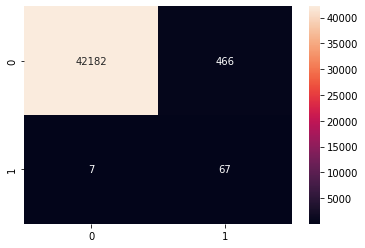

In [23]:
yhat = clf_log_regress.predict(X_validation)
roc_auc_log_regress = round(roc_auc_score(y_validation, yhat), 3)

cm = confusion_matrix(y_validation, yhat)

display(f"Logistic Regression roc_auc_Score: {roc_auc_log_regress}")
ax = sns.heatmap(cm, annot=True, fmt="d")

'Random Forest roc_auc_Score: 0.919'

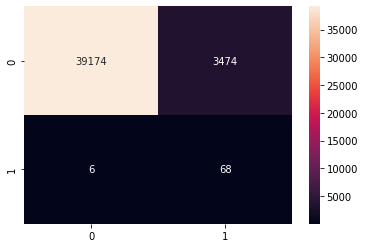

In [24]:
yhat = clf_rand_forest.predict(X_validation)
roc_auc_log_regress = round(roc_auc_score(y_validation, yhat), 3)

cm = confusion_matrix(y_validation, yhat)

display(f"Random Forest roc_auc_Score: {roc_auc_log_regress}")
ax = sns.heatmap(cm, annot=True, fmt="d")

'Support Vector Machine roc_auc_Score: 0.932'

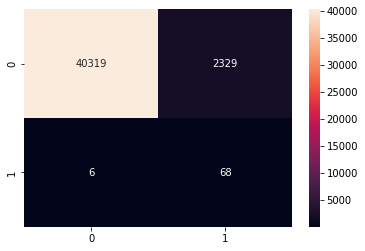

In [25]:
yhat = clf_svm.predict(X_validation)
roc_auc_log_regress = round(roc_auc_score(y_validation, yhat), 3)

cm = confusion_matrix(y_validation, yhat)

display(f"Support Vector Machine roc_auc_Score: {roc_auc_log_regress}")
ax = sns.heatmap(cm, annot=True, fmt="d")

'Gradient Boosting roc_auc_Score: 0.931'

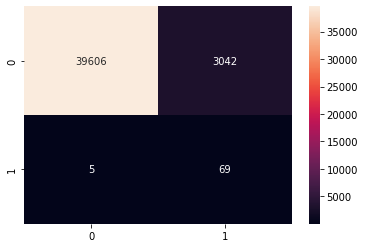

In [26]:
yhat = clf_GBoost.predict(X_validation)
roc_auc_log_regress = round(roc_auc_score(y_validation, yhat), 3)

cm = confusion_matrix(y_validation, yhat)

display(f"Gradient Boosting roc_auc_Score: {roc_auc_log_regress}")
ax = sns.heatmap(cm, annot=True, fmt="d")

<a id='Feauture_Importance'></a>

## Comparison of the Feature Importances for the Different Models
Although nearly all features are from PCA (so little insight possible from analysing the feature importances), it could be interesting to see how similarily each model weigths each of the features. It is of course always important to remember the caveat that feature importance does not mean feature impact.

Below are the calculated [permutation importances](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) for each model based on the validation dataset. 

Clearly features "V14" and "V4" were found to be the most important features for distinguishing between both classes. Further, there are some model specific differences in what features were determined to be useful.

In [27]:
ml_models = {"Logistic Regression": clf_log_regress,
             "Random Forest": clf_rand_forest, 
             "Support Vector Machine": clf_svm, 
             "Gradient Boosting": clf_GBoost}

model_importances = {}
for method, model in ml_models.items():
    results = permutation_importance(model, X, y, scoring="roc_auc", random_state=1)
    unscaled_importances = results.importances_mean
    
    min_max_scaler = MinMaxScaler()
    scaled_importances = min_max_scaler.fit_transform((unscaled_importances.reshape(-1, 1)))
    model_importances[method] = scaled_importances.reshape(1, 29).ravel() #rearrange so plotly happy with it. 

In [28]:
bar_fig = go.Figure(data=[
    go.Bar(name="Logistic Regression", x=bar_df["Feature"], y=model_importances["Logistic Regression"]),
    go.Bar(name="Random Forest", x=bar_df["Feature"], y=model_importances["Random Forest"]),
    go.Bar(name="Support Vector Machine", x=bar_df["Feature"], y=model_importances["Support Vector Machine"]),
    go.Bar(name="Gradient Boosting", x=bar_df["Feature"], y=model_importances["Gradient Boosting"]),
])
bar_fig.update_layout(barmode="group", title="Feature Permutation Importance for each ML Model Evaluated")
bar_fig.update_layout(xaxis=dict(title="Feature Name"), yaxis=dict(title="Normalized Feature Importance"))
bar_fig.show()